In [1]:
! pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 17.2 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SqxHxUmH1bESmMpTc8Wo")
project = rf.workspace("field-planttutorial").project("field-plant")
version = project.version(2)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Field-plant-2 in yolov11:: 100%|██████████| 9862/9862 [00:12<00:00, 789.97it/s] 


In [9]:
# Import necessary libraries
import torch
import os
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
# Define image preprocessing and augmentation
transform = A.Compose([
    A.Resize(640, 640),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.Blur(blur_limit=3, p=0.2)
])

In [11]:
# Path to training images and labels
train_images_path = "/kaggle/working/Field-plant-2/train/images/"
train_labels_path = "/kaggle/working/Field-plant-2/train/labels/"

# Load and preprocess a sample image
sample_image_path = os.path.join(train_images_path, os.listdir(train_images_path)[0])
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
augmented = transform(image=image)["image"]

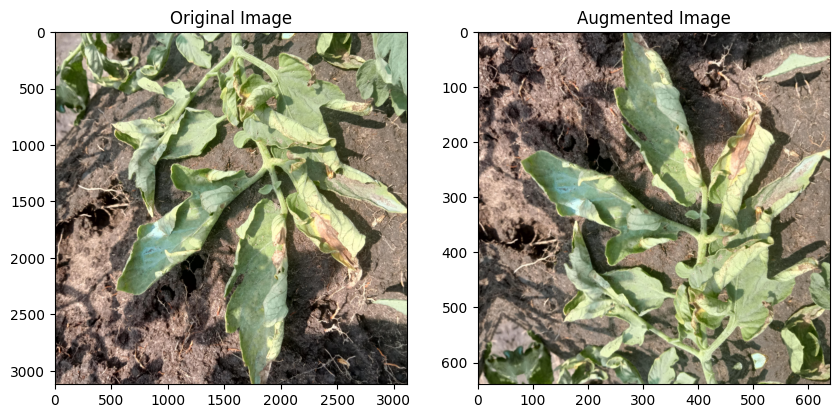

In [12]:
# Display the original and augmented image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(augmented)
ax[1].set_title("Augmented Image")
plt.show()

In [14]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Feature Mapping using PCA
def feature_mapping(image_path, pca_components=10):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (64, 64))  # Resize to 64x64
    img_flat = img.reshape(64, 64)  # Keep 2D structure
    
    scaler = StandardScaler()
    img_scaled = scaler.fit_transform(img_flat)  # Normalize pixel values

    pca = PCA(n_components=min(pca_components, img_scaled.shape[1]))  # Ensure valid component count
    img_pca = pca.fit_transform(img_scaled)  # Apply PCA
    
    return img_pca

# Test with sample image
feature_map = feature_mapping(sample_image_path, pca_components=10)
print("Feature Mapping Output Shape:", feature_map.shape)


Feature Mapping Output Shape: (64, 10)


In [15]:
!yolo detect train data=/kaggle/working/Field-plant-2/data.yaml model=yolo11l.pt epochs=25 imgsz=640 batch=6


100%|███████████████████████████████████████| 49.0M/49.0M [00:00<00:00, 270MB/s]
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/Field-plant-2/data.yaml, epochs=25, time=None, patience=100, batch=6, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, s

In [ ]:
!mkdir -p runs/detect/train/weights/
!cp /kaggle/input/your-uploaded-model/best.pt runs/detect/train/weights/


In [ ]:
!yolo detect train data=/kaggle/working/Field-plant-2/data.yaml \
    model=yolo11m.pt epochs=30 batch=8 lr0=0.0005 imgsz=640 iou=0.65 \
    hsv_h=0.015 hsv_s=0.7 hsv_v=0.4 mosaic=1.5 mixup=0.2 dropout=0.2 \
    cos_lr=True project=/kaggle/working/training_results name=run_finetuned
